### ARIMA vs LSTM 
#### JPMC stock prices (06/29/2017 - 06/28/2023)

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

C:\Users\Aditya Work\AppData\Local\Temp\ipykernel_34760\2769132933.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [37]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Using ARIMA to predict closing price 

In [12]:
df = pd.read_csv("JPMC_stk.csv")
print(df.head(5))
print(df.shape)

         Date       Open       High        Low      Close  Adj Close    Volume
0  2017-06-29  92.339996  92.650002  90.309998  91.150002  76.789742  27697800
1  2017-06-30  91.959999  92.000000  91.160004  91.400002  77.000351  16892700
2  2017-07-03  91.559998  93.480003  91.410004  92.750000  78.567467  13208100
3  2017-07-05  93.120003  93.790001  92.610001  93.680000  79.355270  17535400
4  2017-07-06  93.540001  94.510002  92.879997  93.379997  79.101143  16596100
(1509, 7)


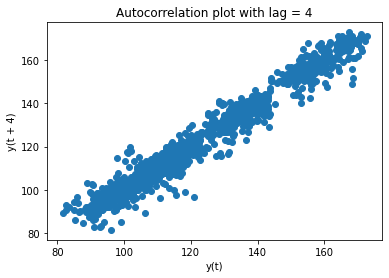

In [10]:
# Plotting scatter plot with lag=4 to check for auto correlation

plt.figure()
lag_plot(df['Open'], lag=4)
plt.title('Autocorrelation plot with lag = 4')
plt.show()


We can use ARIMA since since there is here a  is +ve auto-correlation in the data

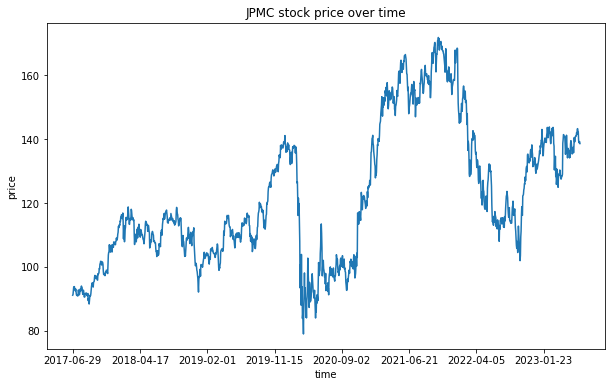

In [14]:
# Plotting the prices over time
plt.figure(figsize=(10, 6))
plt.plot(df["Date"], df["Close"])
plt.xticks(np.arange(0,1510, 200), df['Date'][0:1510:200])
plt.title("JPMC stock price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

In [28]:
# creating the model and splitting df into train(0.7) and test (0.3)

train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]

train_data=train_data['Close'].values
test_data=test_data['Close'].values

n_test_data=len(test_data)
predictions=[]
history=list(train_data)


In [30]:
for i in range(n_test_data):
    model= ARIMA(history, order=(4,1,0))
    model_fit = model.fit()
    pred=model_fit.forecast()
    y=pred[0]
    predictions.append(y)
    actual_test_val=test_data[i]
    history.append(actual_test_val)
    
MSE_error = mean_squared_error(test_data, predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 5.451342264141799


Achieving an MSE of 5.45 for stock price prediction within the given target value range(roughly 80 to 180) can be seen as a positive outcome. Let’s visualize the predictions to understand the performance of the model more.

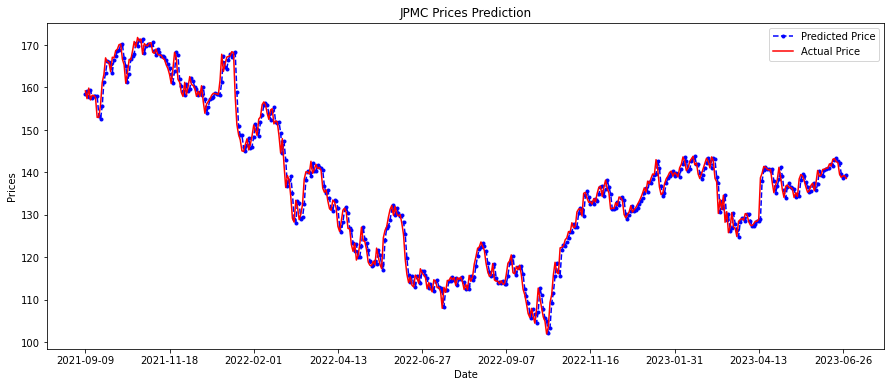

In [36]:
test_set_range = df[int(len(df)*0.7):].index
plt.figure(figsize=(15, 6))
plt.plot(test_set_range, predictions, color='blue', marker='.', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('JPMC Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(1056,1510,50), df.Date[1056:1510:50])
plt.legend()
plt.show()

## Using LSTM to predict prices

In [68]:
data = df[['Date', 'Open', 'High', 'Low', 'Close']].values
data

array([['2017-06-29', 92.339996, 92.650002, 90.309998, 91.150002],
       ['2017-06-30', 91.959999, 92.0, 91.160004, 91.400002],
       ['2017-07-03', 91.559998, 93.480003, 91.410004, 92.75],
       ...,
       ['2023-06-26', 138.869995, 140.009995, 137.690002, 139.190002],
       ['2023-06-27', 139.0, 139.839996, 138.539993, 139.199997],
       ['2023-06-28', 139.160004, 139.210007, 137.960007, 138.589996]],
      dtype=object)

In [69]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[:, 1:5])

In [70]:
data_scaled

array([[0.11826656, 0.09976461, 0.14311648, 0.13067389],
       [0.11409764, 0.09247841, 0.15219483, 0.1333693 ],
       [0.10970926, 0.10906852, 0.15486491, 0.14792454],
       ...,
       [0.62874373, 0.63064668, 0.64915097, 0.64862537],
       [0.63017001, 0.62874108, 0.65822916, 0.64873313],
       [0.6319254 , 0.62167921, 0.65203471, 0.6421563 ]])

In [71]:
# Generate input sequences and corresponding target values
X, y = [], []
n=60
for i in range(n, len(data_scaled)):
    X.append(data_scaled[i-n:i])
    y.append(data_scaled[i, -1])
    
X = np.array(X)
y = np.array(y)

In [72]:
# Split the data into training and testing sets
split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [73]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=250, activation='relu', return_sequences=True,input_shape=(n, 4)))
model.add(Dropout(0.2))
model.add(LSTM(units=250, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=120, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=60, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=10,batch_size=32)

Epoch 1/10
32/32 [==============================] - 12s 269ms/step - loss: 0.0247
Epoch 2/10
32/32 [==============================] - 9s 285ms/step - loss: 0.0100
Epoch 3/10
32/32 [==============================] - 9s 288ms/step - loss: 0.0083
Epoch 4/10
32/32 [==============================] - 9s 289ms/step - loss: 0.0074
Epoch 5/10
32/32 [==============================] - 9s 288ms/step - loss: 0.0065
Epoch 6/10
32/32 [==============================] - 9s 290ms/step - loss: 0.0068
Epoch 7/10
32/32 [==============================] - 9s 289ms/step - loss: 0.0051
Epoch 8/10
32/32 [==============================] - 9s 288ms/step - loss: 0.0053
Epoch 9/10
32/32 [==============================] - 9s 288ms/step - loss: 0.0050
Epoch 10/10
32/32 [==============================] - 9s 292ms/step - loss: 0.0050


In [75]:
# Make predictions
predictions = model.predict(X_test)

# Denormalize the predictions and actual values
predictions = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], predictions), axis=1))[:, -1]
actual_values = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], y_test.reshape(-1, 1)), axis=1))[:, -1]


14/14 [==============================] - 2s 98ms/step


In [106]:
mse = mean_squared_error(actual_values, predictions)
print('Testing Mean Squared Error is ',mse)

Testing Mean Squared Error is  48.43530177885263


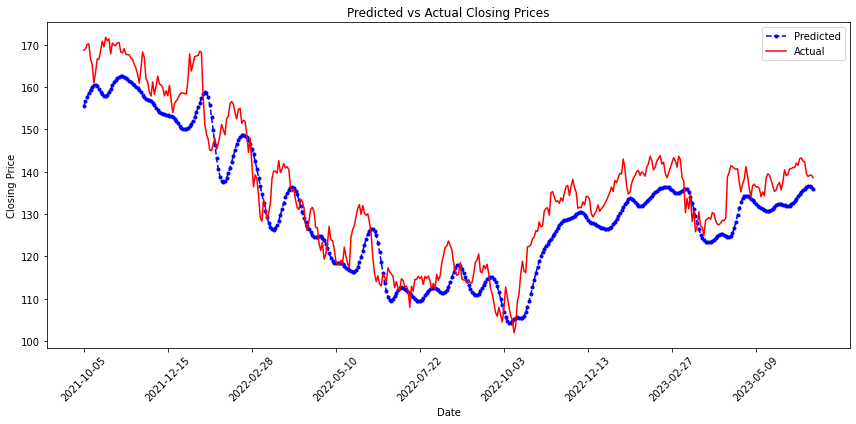

In [107]:
dates = df['Date'].values[split + n:]

# Plotting the predicted and actual closing prices
plt.figure(figsize=(12, 6))
plt.plot(dates, predictions, color='blue', marker='.', linestyle='dashed',label='Predicted')
plt.plot(dates, actual_values, color='red', label='Actual')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Predicted vs Actual Closing Prices')

# Select every 50th date index for x-axis tick labels
x_tick_indices = np.arange(0, len(dates), 50)

# Set the x-axis tick labels to the corresponding dates
plt.xticks(x_tick_indices, dates[x_tick_indices], rotation=45)

plt.legend()
plt.tight_layout()
plt.show()

We got better results with out ARIMA model as compared to our LSTM model. This could be because the performance of LSTM models heavily depends on hyperparameter tuning, such as the number of LSTM layers, hidden units, learning rate, and sequence length. If the LSTM model was not properly tuned or the hyperparameters were not optimized for the specific dataset, it could result in suboptimal performance compared to ARIMA. The stock price data may have exhibited a linear or stationary behavior that is well-suited for ARIMA models. ARIMA models are designed to capture linear trends and stationary patterns in time series data. If the stock prices followed a relatively predictable pattern without complex non-linear dependencies, ARIMA could outperform LSTM.